# **Model Selection to estimate Agents**

For each station, find a good model to predict the individual pollutants.

## **Input Data**

Using the process defined in the [training data notebook](./4-training-and-test-sets.ipynb), initiate the datasets.

In [76]:
%load_ext autoreload
%autoreload 2

from datetime import datetime

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Metrics
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error, mean_squared_error

from sklearn.model_selection import train_test_split

from utils import *

datasets_folder = './datasets'
figsize = (20,4)
verbosity = 0

metrics = [root_mean_squared_error, r2_score, mean_absolute_error, mean_squared_error]

tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [77]:
pollution_data = read_and_preprocess_dataset(datasets_folder, 'pollution', v=verbosity)
traffic_data = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity, radius=2)
weather_data = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

stations = pollution_data.keys()

In [78]:
station_data = {}
station_dists = {}
date_encoding = 'radial_months-sin-cos_days_hours'

for station in stations:
    station_data[station], station_dists[station] = prepare_station_data_for_training(
        pollution_data[station], 
        traffic_data[station], 
        weather_data, 
        encoding_method=date_encoding,
        # weather merging parameters:
        aggregations = DEFAULT_AGGREGATIONS,
        max_min_columns = DEFAULT_MAX_MIN_COLUMNS, 
        # traffic merging parameters:
        bin_size = 3,
        offset = 0
    )
    
    print(f'Station {station} agents: ',', '.join(list(station_data[station].keys())))

n_hour_features = len(station_data['GIARDINI MARGHERITA']['NO2'].columns) - 1 # -1 because Agent_value is the target
n_daily_features = len(station_data['GIARDINI MARGHERITA']['PM2.5'].columns) - 1 # -1 because Agent_value is the target
print(f'Total number of hourly features: {n_hour_features}')
print(f'Total number of daily features: {n_daily_features}')

Station GIARDINI MARGHERITA agents:  NO2, O3, PM10, PM2.5
Station PORTA SAN FELICE agents:  C6H6, CO, NO2, PM10, PM2.5
Station VIA CHIARINI agents:  NO2, O3, PM10
Total number of hourly features: 24
Total number of daily features: 33


## **Training Data**

In [79]:
train_split_date = datetime(2023,12,31,23)
RANDOM_STATE = 42

In [132]:
train_sets = {}
test_sets = {}

for station in stations:
    train_sets[station] = {}
    test_sets[station] = {}
    for agent in station_data[station].keys():
        train_sets[station][agent] = {}
        test_sets[station][agent] = {}

        X_train, y_train, X_test, y_test = create_train_test(station_data[station][agent], train_split_date, y='Agent_value')

        train_sets[station][agent]['x'] = X_train
        train_sets[station][agent]['y'] = y_train
        test_sets[station][agent]['x'] = X_test
        test_sets[station][agent]['y'] = y_test

- Merge the data of the agents between the stations.

In [133]:
def merge_train_sets(train_sets):
    merged_train = {}
    for station in train_sets.keys():
        for agent in train_sets[station].keys():
            if agent not in merged_train:
                merged_train[agent] = {}
                merged_train[agent]['x'] = pd.DataFrame()
                merged_train[agent]['y'] = pd.DataFrame()
            merged_train[agent]['x'] = pd.concat([merged_train[agent]['x'], train_sets[station][agent]['x']], axis=0)
            merged_train[agent]['y'] = pd.concat([merged_train[agent]['y'], train_sets[station][agent]['y']], axis=0)
    return merged_train

merged_train_sets = merge_train_sets(train_sets)
for agent in merged_train_sets.keys():
    print(f'Agent {agent} train set shape: \t{merged_train_sets[agent]["x"].shape}, {merged_train_sets[agent]["y"].shape}')

Agent NO2 train set shape: 	(128614, 24), (128614, 1)
Agent O3 train set shape: 	(85826, 24), (85826, 1)
Agent PM10 train set shape: 	(5283, 33), (5283, 1)
Agent PM2.5 train set shape: 	(3519, 33), (3519, 1)
Agent C6H6 train set shape: 	(40778, 24), (40778, 1)
Agent CO train set shape: 	(43036, 24), (43036, 1)


## **Models**

### **Hourly Models**

In [82]:
hour_models = {} # contains tuples: (ModelGenerator, model_params:dict, training_params:dict|None, uses_sequences:bool)

#### Random Forest Regressor

##### *Models*

In [83]:
rfr_params = {
    'n_estimators':300,
    'max_depth':20,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE
}

hour_models['Random Forest Regressor'] = (RandomForestRegressor, rfr_params, None, False)

In [84]:
rfr2_params = {
    'n_estimators':500,
    'max_depth':15,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE
}

hour_models['Random Forest Regressor 2'] = (RandomForestRegressor, rfr2_params, None, False)

##### *Testing*

In [85]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_rfr = 'Random Forest Regressor'

In [86]:
rfr_model = RandomForestRegressor(**hour_models[selected_rfr][1])
rfr_model.fit(merged_train_sets[agent]['x'], merged_train_sets[agent]['y'].to_numpy().ravel())
rfr_pred = rfr_model.predict(test_sets[station][agent]['x'])
rfr_pred_df = pd.DataFrame(rfr_pred, index=test_sets[station][agent]['y'].index)

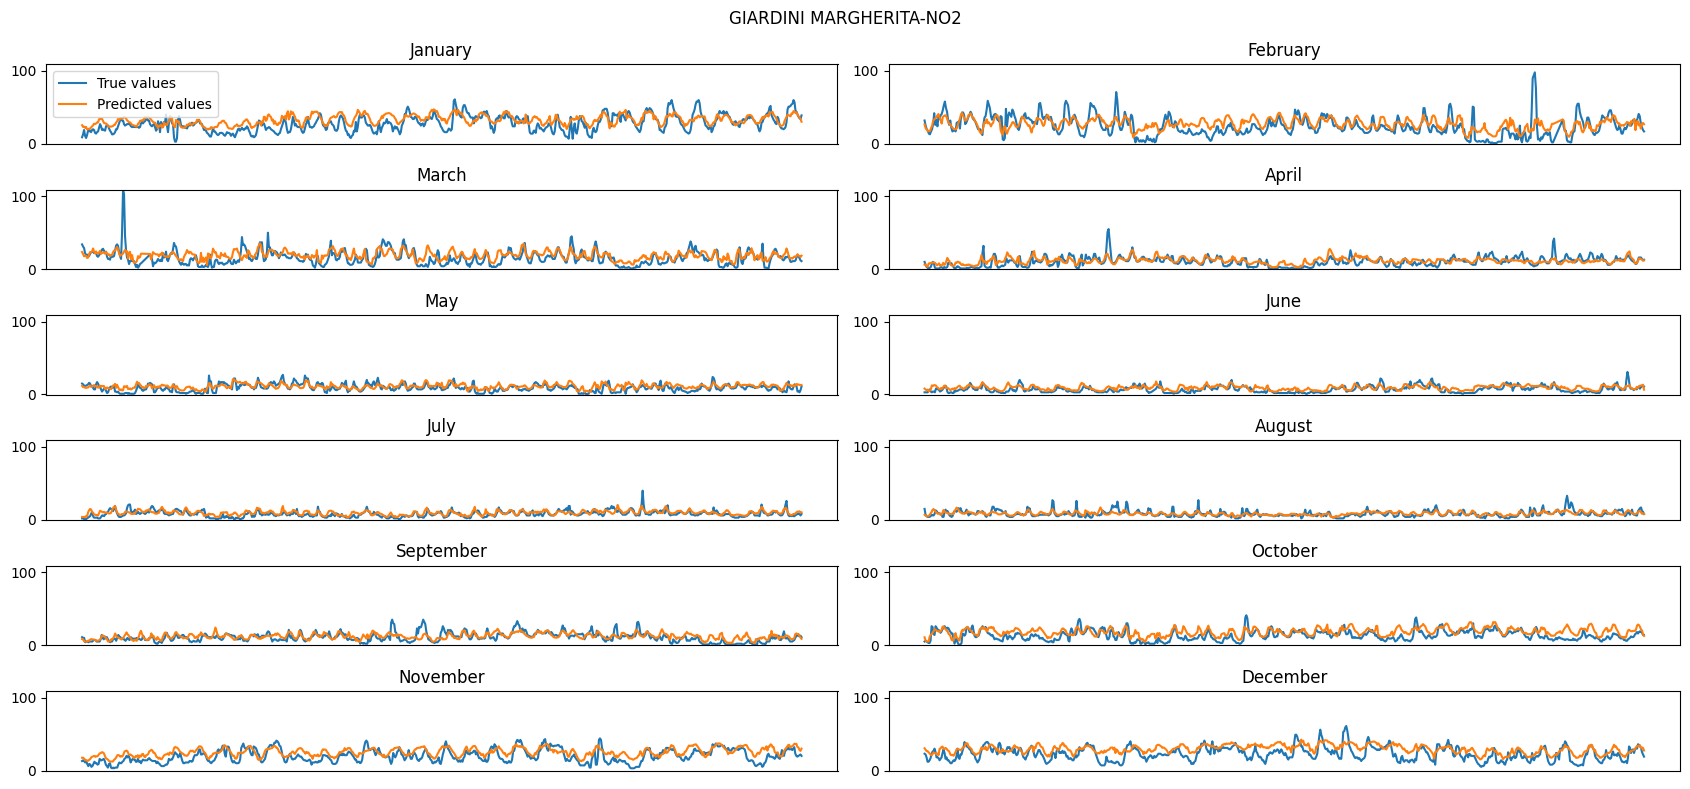

root_mean_squared_error: 0.5939949625236585
r2_score: 0.4994578371512872
mean_absolute_error: 0.4410370667320577
mean_squared_error: 0.3528300155034824


In [87]:
plot_months_predictions(test_sets[station][agent]['y'], rfr_pred_df, dist_dict=station_dists[station][agent], metrics=metrics, title=f'{station}-{agent}')

#### XGBoost

##### *Models*

In [88]:
xgbr_params = {
    'objective': "reg:absoluteerror",
    'n_estimators': 180,
    'max_depth': 6,
    'learning_rate': 0.07,
    'subsample': 0.9,
    'random_state': RANDOM_STATE
}

hour_models['XGB Regressor'] = (xgb.XGBRegressor, xgbr_params, None, False)

In [89]:
xgbr2_params = {
    'objective': "reg:squarederror",
    'n_estimators': 250,
    'max_depth': 10,
    'learning_rate': 0.1,
    'subsample': 0.75,
    'random_state': RANDOM_STATE
}

hour_models['XGB Regressor 2'] = (xgb.XGBRegressor, xgbr2_params, None, False)

##### *Testing*

In [90]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_xgbr = 'XGB Regressor'

In [91]:
validation_ratio = 0.1

X_train, y_train = merged_train_sets[agent]['x'], merged_train_sets[agent]['y']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_ratio, random_state=42, shuffle=True)
validation_data = [(X_val, y_val)]

xgbr_model = xgb.XGBRegressor(**hour_models[selected_xgbr][1])
xgbr_model.fit(X_train, y_train, eval_set=validation_data)
xgbr_pred = xgbr_model.predict(test_sets[station][agent]['x'])
xgbr_pred_df = pd.DataFrame(xgbr_pred, index=test_sets[station][agent]['y'].index)

[0]	validation_0-mae:0.77953
[1]	validation_0-mae:0.75137
[2]	validation_0-mae:0.72547
[3]	validation_0-mae:0.70278
[4]	validation_0-mae:0.68117
[5]	validation_0-mae:0.66214
[6]	validation_0-mae:0.64445
[7]	validation_0-mae:0.62880
[8]	validation_0-mae:0.61438
[9]	validation_0-mae:0.60198
[10]	validation_0-mae:0.59046
[11]	validation_0-mae:0.57970
[12]	validation_0-mae:0.56991
[13]	validation_0-mae:0.56098
[14]	validation_0-mae:0.55283
[15]	validation_0-mae:0.54538
[16]	validation_0-mae:0.53808
[17]	validation_0-mae:0.53209
[18]	validation_0-mae:0.52646
[19]	validation_0-mae:0.52107
[20]	validation_0-mae:0.51603
[21]	validation_0-mae:0.51136
[22]	validation_0-mae:0.50703
[23]	validation_0-mae:0.50335
[24]	validation_0-mae:0.49931
[25]	validation_0-mae:0.49595
[26]	validation_0-mae:0.49309
[27]	validation_0-mae:0.49038
[28]	validation_0-mae:0.48785
[29]	validation_0-mae:0.48545
[30]	validation_0-mae:0.48313
[31]	validation_0-mae:0.48107
[32]	validation_0-mae:0.47925
[33]	validation_0-ma

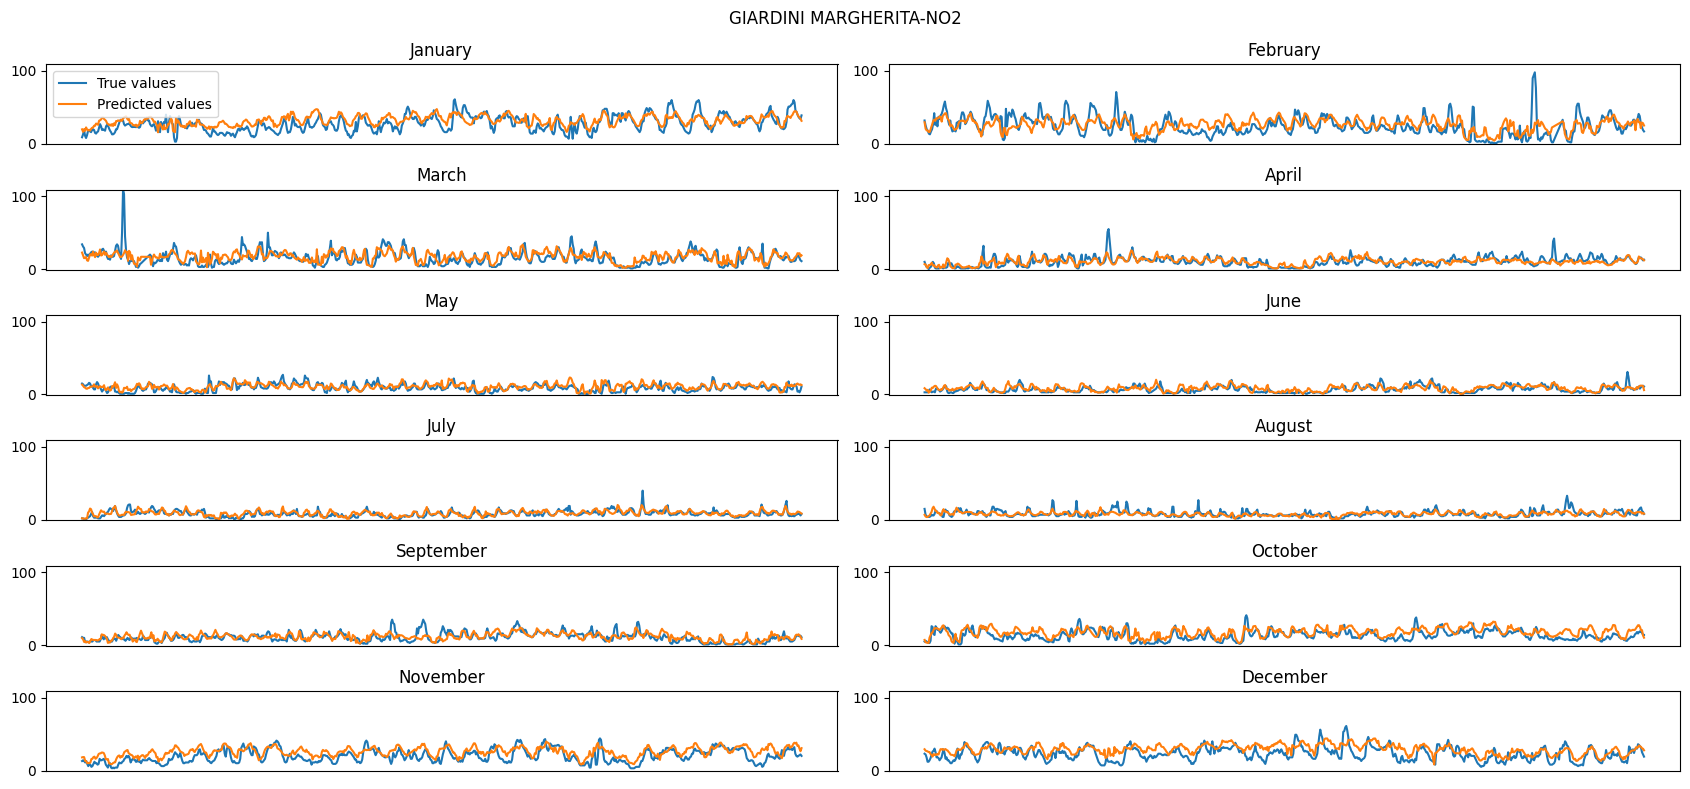

root_mean_squared_error: 0.5796039261251177
r2_score: 0.5234178420936029
mean_absolute_error: 0.41795505789993537
mean_squared_error: 0.33594071117965085


In [92]:
plot_months_predictions(test_sets[station][agent]['y'], xgbr_pred_df, dist_dict=station_dists[station][agent], metrics=metrics, title=f'{station}-{agent}')

#### LSTM

##### *Models*

In [93]:
lstm_params = {
    'time_steps': 3,
    'n_features': n_hour_features,
    'lstm_units': 128,
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_absolute_error',
    'use_mask': False # fill nan using bfill()
}

lstm_train_params = {
    'epochs':20,
    'batch_size':64,
}

hour_models['LSTM'] = (build_lstm_model, lstm_params, lstm_train_params, True)

In [94]:
masked_lstm_params = {
    'time_steps': 3,
    'n_features': n_hour_features,
    'lstm_units': 128,
    'optimizer': Adam(learning_rate=3e-4),
    'loss': 'mean_absolute_error',
    'use_mask': True # apply a mask to nan, instead of filling
}

masked_lstm_train_params = {
    'epochs':50,
    'batch_size':32,
}

hour_models['LSTM-masked'] = (build_lstm_model, masked_lstm_params, masked_lstm_train_params, True)

In [95]:
lstm2_params = {
    'time_steps': 5,
    'n_features': n_hour_features,
    'lstm_units': [64, 32],
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_squared_error',
    'use_mask': False
}

lstm2_train_params = {
    'epochs':20,
    'batch_size':32,
}

hour_models['LSTM 2'] = (build_lstm_model, lstm2_params, lstm2_train_params, True)


In [96]:
masked_lstm2_params = {
    'time_steps': 5,
    'n_features': n_hour_features,
    'lstm_units': [64, 32],
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_squared_error',
    'use_mask': True
}

masked_lstm2_train_params = {
    'epochs':20,
    'batch_size':32,
}

hour_models['LSTM 2-masked'] = (build_lstm_model, masked_lstm2_params, masked_lstm2_train_params, True)


##### *Testing*

In [97]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_lstm = 'LSTM'

In [ ]:
validation_ratio = 0.1
selected_lstm_model = hour_models[selected_lstm]

ts = selected_lstm_model[1]['time_steps']

lstm_X_train, lstm_y_train = None, None
for station in stations:
    if agent in train_sets[station].keys():
        X_train, y_train = create_sequences(train_sets[station][agent]['x'], train_sets[station][agent]['y'], ts, use_mask=False)
        if lstm_X_train is None:
            lstm_X_train = X_train
            lstm_y_train = y_train
        else:
            lstm_X_train = np.concatenate((lstm_X_train, X_train), axis=0)
            lstm_y_train = np.concatenate((lstm_y_train, y_train), axis=0)

lstm_X_test = pd.concat([train_sets[station][agent]['x'].iloc[-ts+1:], test_sets[station][agent]['x']]) # to also compute the first days we need time_steps more days
lstm_X_test, lstm_y_test = create_sequences(lstm_X_test, test_sets[station][agent]['y'], ts, use_mask=False)

lstm_X_train, lstm_X_val, lstm_y_train, lstm_y_val = train_test_split(lstm_X_train, lstm_y_train, test_size=validation_ratio, random_state=42, shuffle=True)

Epoch 1/20
1809/1809 [==============================] - 12s 5ms/step - loss: 0.4883 - val_loss: 0.4733
Epoch 2/20
1809/1809 [==============================] - 8s 4ms/step - loss: 0.4699 - val_loss: 0.4694
Epoch 3/20
1809/1809 [==============================] - 7s 4ms/step - loss: 0.4618 - val_loss: 0.4590
Epoch 4/20
1809/1809 [==============================] - 8s 4ms/step - loss: 0.4562 - val_loss: 0.4596
Epoch 5/20
1809/1809 [==============================] - 7s 4ms/step - loss: 0.4502 - val_loss: 0.4505
Epoch 6/20
1809/1809 [==============================] - 7s 4ms/step - loss: 0.4445 - val_loss: 0.4466
Epoch 7/20
1809/1809 [==============================] - 7s 4ms/step - loss: 0.4394 - val_loss: 0.4451
Epoch 8/20
1809/1809 [==============================] - 7s 4ms/step - loss: 0.4357 - val_loss: 0.4402
Epoch 9/20
1809/1809 [==============================] - 7s 4ms/step - loss: 0.4309 - val_loss: 0.4384
Epoch 10/20
1809/1809 [==============================] - 7s 4ms/step - loss: 0.42

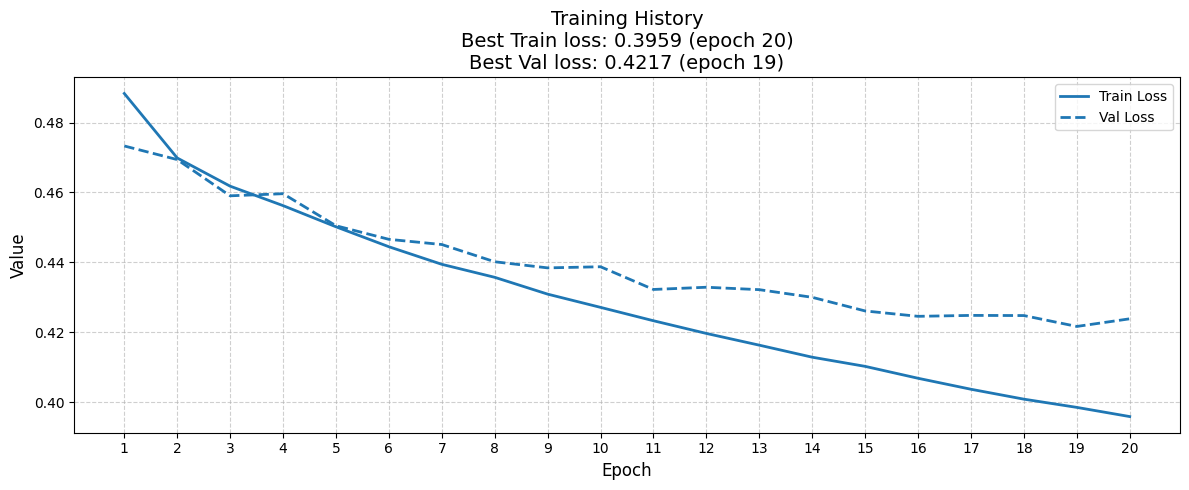

273/273 [==============================] - 1s 1ms/step


In [99]:
selected_lstm_model = hour_models[selected_lstm]
tf.keras.backend.clear_session()  # Reset TensorFlow state
set_random_seed(42) 
lstm_model = selected_lstm_model[0](**selected_lstm_model[1])
lstm_history = lstm_model.fit(
    lstm_X_train,
    lstm_y_train,
    validation_data=(lstm_X_val, lstm_y_val),
    **selected_lstm_model[2],
)
plot_history(lstm_history)
lstm_pred = lstm_model.predict(lstm_X_test)
lstm_pred_df = pd.DataFrame(lstm_pred, index=lstm_y_test.index)

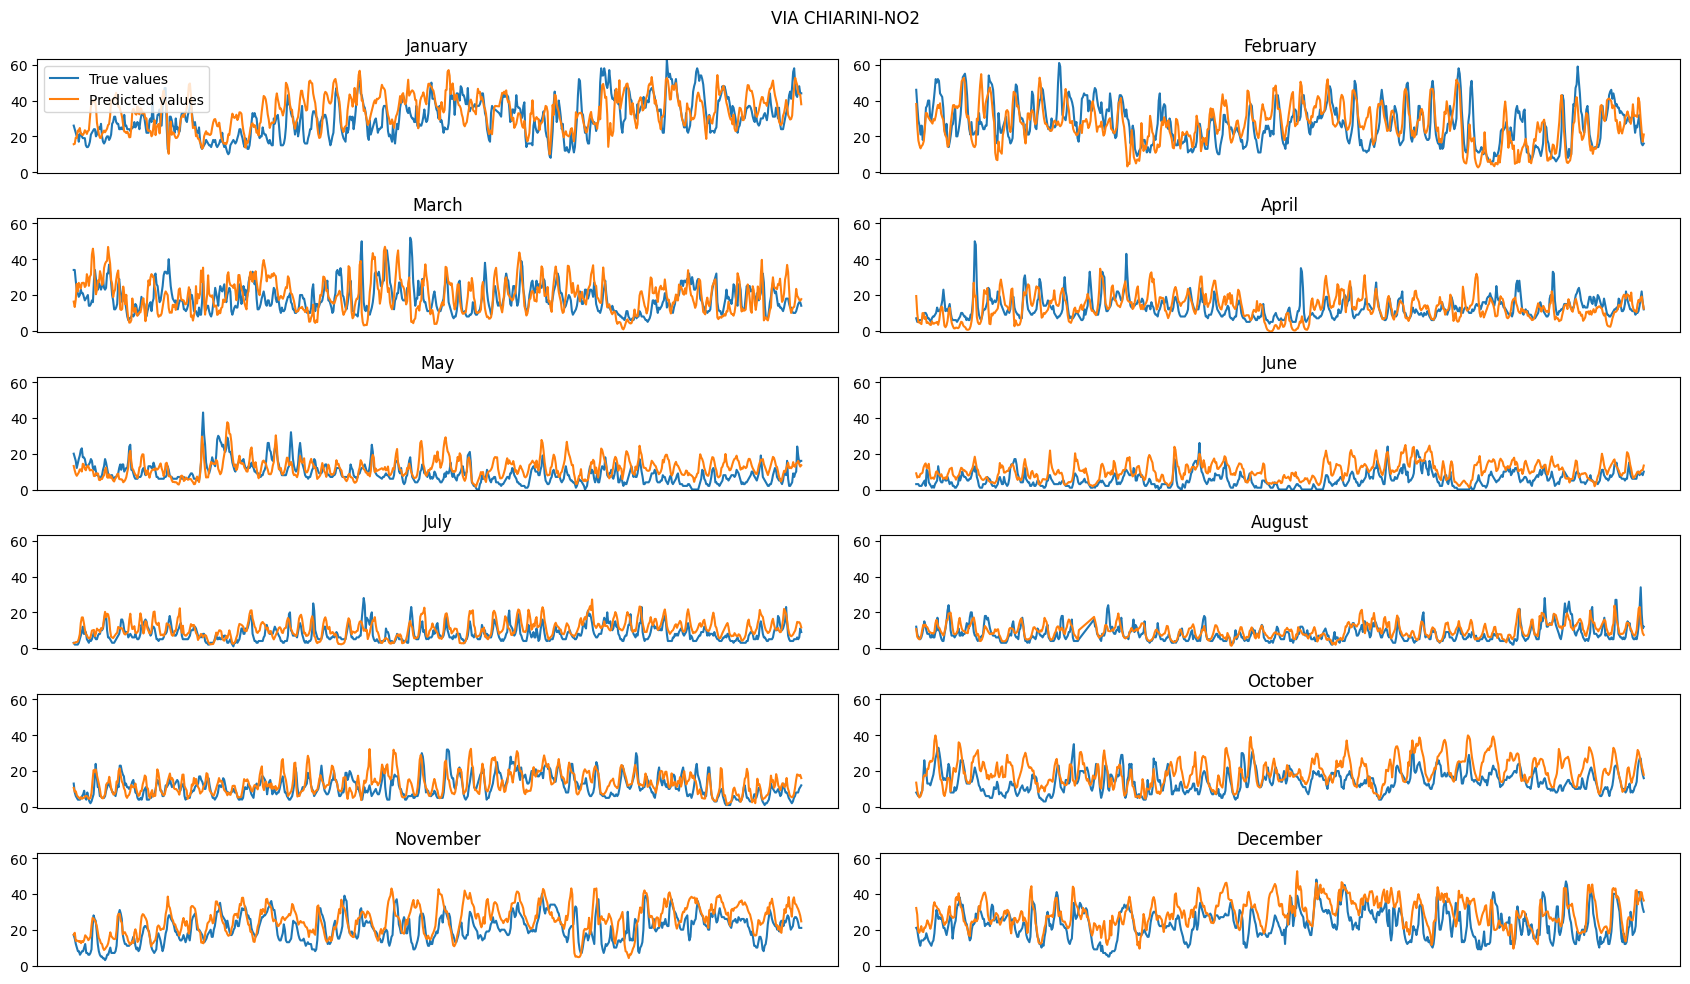

root_mean_squared_error: 0.5821826538840584
r2_score: 0.4505077104660735
mean_absolute_error: 0.44688053841444864
mean_squared_error: 0.3389366424834854


In [100]:
plot_months_predictions(lstm_y_test, lstm_pred_df, dist_dict=station_dists[station][agent], metrics=metrics, title=f'{station}-{agent}', figsize=(17,10))

#### Feed Forward Neural Network

##### *Models*

In [101]:
ffnn_params = {
    'input_size': n_hour_features,
    'neurons': [1024, 512, 256, 128],
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_absolute_error'
}

ffnn_train_params = {
    'epochs':10,
    'batch_size':32,
}

hour_models['Feed Forward NN'] = (build_ffnn_model, ffnn_params, ffnn_train_params, False)

In [ ]:
ffnn2_params = {
    'input_size': n_hour_features,
    'neurons': [512, 256, 128],
    'dropout': 0.3,
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_absolute_error'
}

ffnn2_train_params = {
    'epochs':10,
    'batch_size':32,
}

hour_models['Feed Forward NN 2'] = (build_ffnn_model, ffnn2_params, ffnn2_train_params, False)

##### *Testing*

In [134]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_ffnn = 'Feed Forward NN'

Epoch 1/10
3618/3618 [==============================] - 17s 5ms/step - loss: 0.5266 - val_loss: 0.5032
Epoch 2/10
3618/3618 [==============================] - 17s 5ms/step - loss: 0.5092 - val_loss: 0.5021
Epoch 3/10
3618/3618 [==============================] - 17s 5ms/step - loss: 0.5021 - val_loss: 0.5077
Epoch 4/10
3618/3618 [==============================] - 16s 5ms/step - loss: 0.4971 - val_loss: 0.4873
Epoch 5/10
3618/3618 [==============================] - 17s 5ms/step - loss: 0.4930 - val_loss: 0.4811
Epoch 6/10
3618/3618 [==============================] - 17s 5ms/step - loss: 0.4897 - val_loss: 0.4904
Epoch 7/10
3618/3618 [==============================] - 17s 5ms/step - loss: 0.4871 - val_loss: 0.4800
Epoch 8/10
3618/3618 [==============================] - 17s 5ms/step - loss: 0.4849 - val_loss: 0.4742
Epoch 9/10
3618/3618 [==============================] - 17s 5ms/step - loss: 0.4819 - val_loss: 0.4728
Epoch 10/10
3618/3618 [==============================] - 17s 5ms/step - l

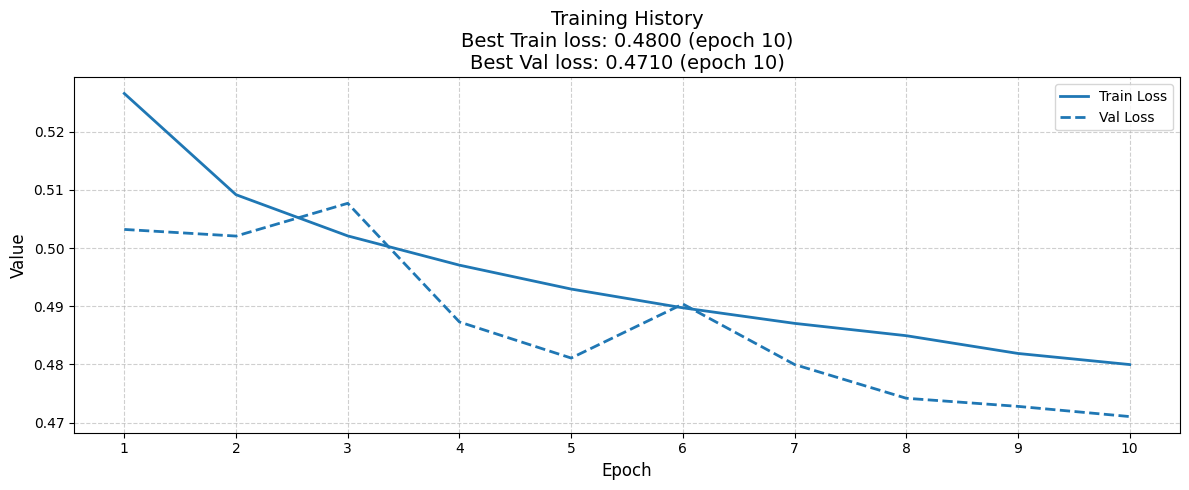

273/273 [==============================] - 1s 3ms/step


In [137]:
tf.keras.backend.clear_session()  
set_random_seed(42) 

validation_ratio = 0.1
X_train, y_train = merged_train_sets[agent]['x'], merged_train_sets[agent]['y']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_ratio, random_state=42, shuffle=True)
validation_data = [(X_val, y_val)]

ffnn_model = build_ffnn_model(**hour_models[selected_ffnn][1])
ffnn_history = ffnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    **hour_models[selected_ffnn][2]
)
plot_history(ffnn_history)
ffnn_pred = ffnn_model.predict(test_sets[station][agent]['x'])
ffnn_pred_df = pd.DataFrame(ffnn_pred, index=test_sets[station][agent]['y'].index)

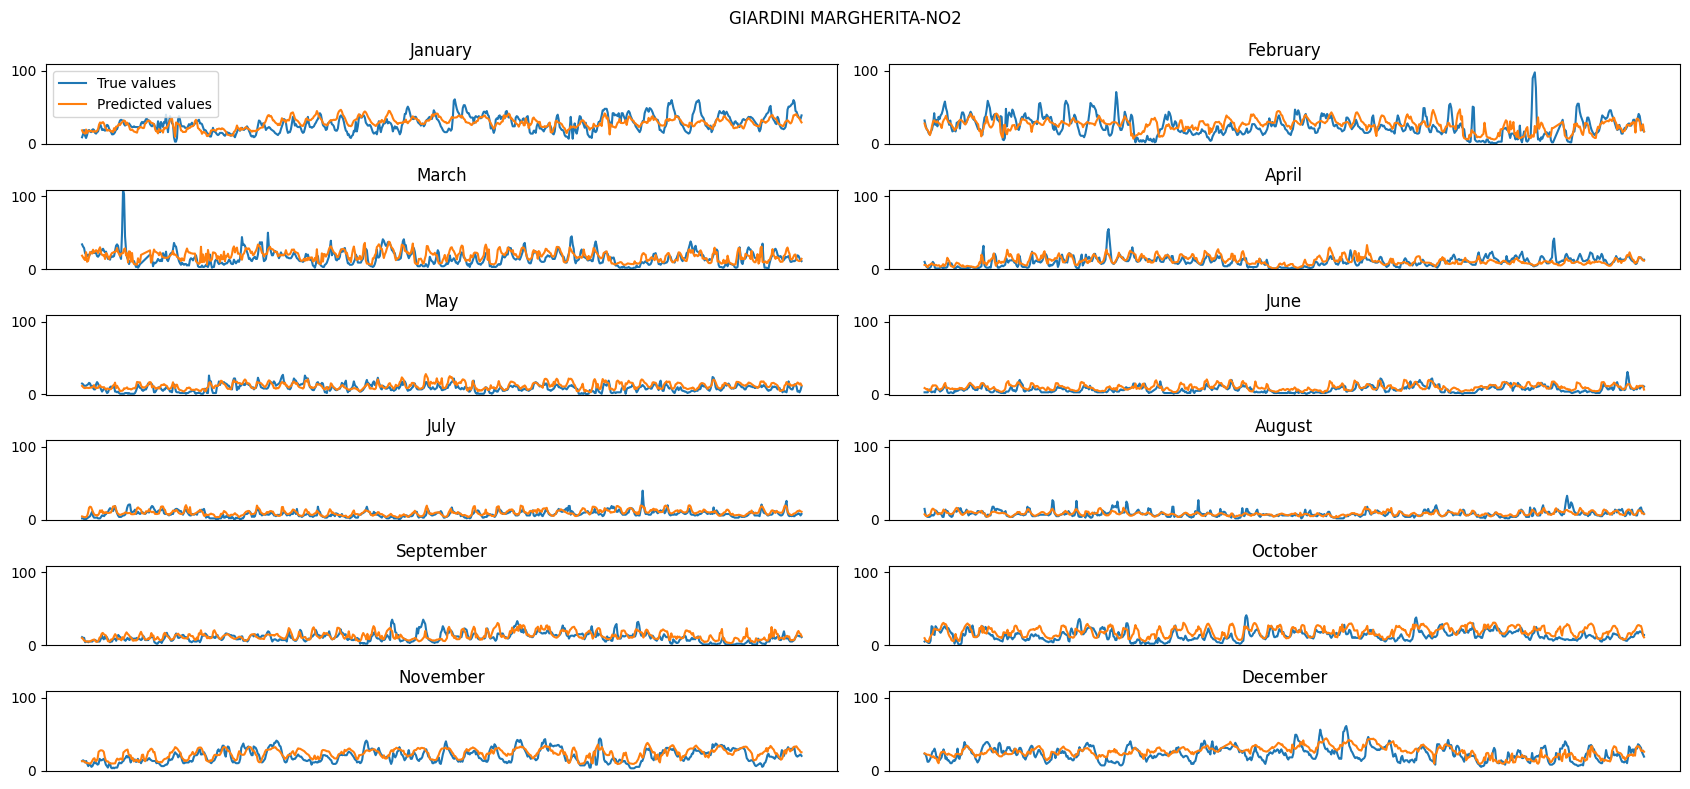

root_mean_squared_error: 0.5986591040741364
r2_score: 0.49156630450207917
mean_absolute_error: 0.4382416829566356
mean_squared_error: 0.35839272289084767


In [138]:
plot_months_predictions(test_sets[station][agent]['y'], ffnn_pred_df, dist_dict=station_dists[station][agent], metrics=metrics, title=f'{station}-{agent}')

#### Conv1d

##### *Models*

In [106]:
conv_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': 64,
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv_train_params = {
    'epochs': 10,
    'batch_size': 64,
}

hour_models['Conv1D'] = (build_conv_model, conv_params, conv_train_params, True)

In [107]:
conv2_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': [64, 32],
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv2_train_params = {
    'epochs': 10,
    'batch_size': 64,
}

hour_models['Conv1D 2'] = (build_conv_model, conv2_params, conv2_train_params, True)

In [108]:
conv3_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': [64, 32],
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv3_train_params = {
    'epochs': 20,
    'batch_size': 32,
}

hour_models['Conv1D 3'] = (build_conv_model, conv3_params, conv3_train_params, True)

##### *Testing*

In [109]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_conv = 'Conv1D'

In [110]:
validation_ratio = 0.1
selected_conv_model = hour_models[selected_conv]

ts = selected_conv_model[1]['time_steps']
# lstm_X_train, lstm_y_train = create_sequences(train_sets[station][agent]['x'], train_sets[station][agent]['y'], ts, use_mask=False)

conv_X_train, conv_y_train = None, None
for station in stations:
    if agent in train_sets[station].keys():
        X_train, y_train = create_sequences(train_sets[station][agent]['x'], train_sets[station][agent]['y'], ts, use_mask=False)
        if conv_X_train is None:
            conv_X_train = X_train
            conv_y_train = y_train
        else:
            conv_X_train = np.concatenate((conv_X_train, X_train), axis=0)
            conv_y_train = np.concatenate((conv_y_train, y_train), axis=0)

conv_X_test = pd.concat([train_sets[station][agent]['x'].iloc[-ts+1:], test_sets[station][agent]['x']]) # to also compute the first days we need time_steps more days
conv_X_test, conv_y_test = create_sequences(conv_X_test, test_sets[station][agent]['y'], ts, use_mask=False)

conv_X_train, conv_X_val, conv_y_train, conv_y_val = train_test_split(conv_X_train, conv_y_train, test_size=validation_ratio, random_state=42, shuffle=True)

Epoch 1/10
1809/1809 [==============================] - 3s 2ms/step - loss: 0.4929 - val_loss: 0.4720
Epoch 2/10
1809/1809 [==============================] - 3s 2ms/step - loss: 0.4722 - val_loss: 0.4693
Epoch 3/10
1809/1809 [==============================] - 3s 2ms/step - loss: 0.4638 - val_loss: 0.4695
Epoch 4/10
1809/1809 [==============================] - 3s 2ms/step - loss: 0.4572 - val_loss: 0.4555
Epoch 5/10
1809/1809 [==============================] - 3s 2ms/step - loss: 0.4531 - val_loss: 0.4505
Epoch 6/10
1809/1809 [==============================] - 3s 2ms/step - loss: 0.4493 - val_loss: 0.4479
Epoch 7/10
1809/1809 [==============================] - 3s 2ms/step - loss: 0.4458 - val_loss: 0.4497
Epoch 8/10
1809/1809 [==============================] - 3s 2ms/step - loss: 0.4427 - val_loss: 0.4451
Epoch 9/10
1809/1809 [==============================] - 3s 2ms/step - loss: 0.4393 - val_loss: 0.4450
Epoch 10/10
1809/1809 [==============================] - 3s 2ms/step - loss: 0.437

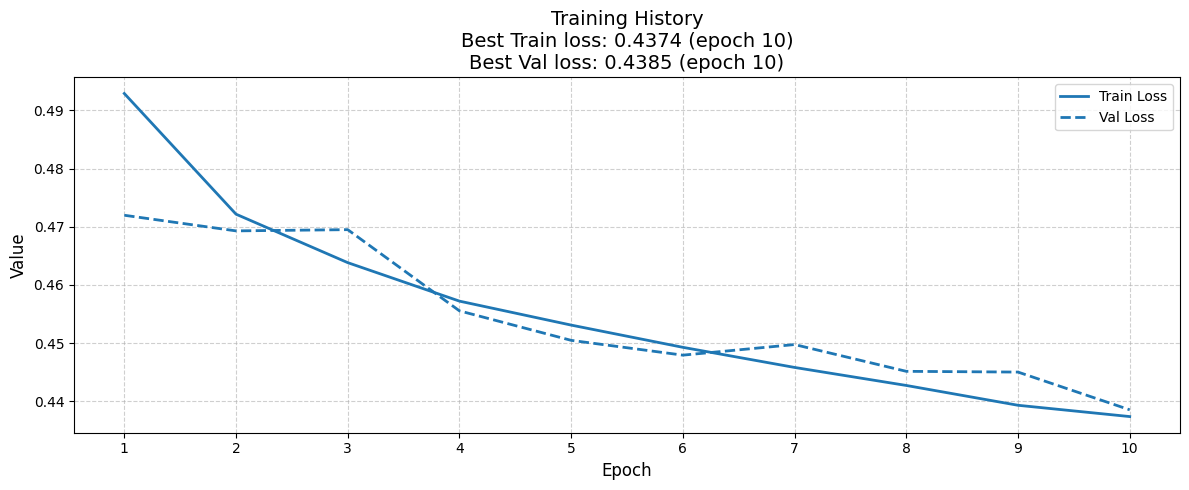

273/273 [==============================] - 0s 682us/step


In [111]:
tf.keras.backend.clear_session()  
set_random_seed(42) 
conv_model = build_conv_model(**hour_models[selected_conv][1])
conv_history = conv_model.fit(
    conv_X_train, 
    conv_y_train,
    validation_data=(conv_X_val, conv_y_val),
    **hour_models[selected_conv][2])
plot_history(conv_history)
conv_pred = conv_model.predict(conv_X_test)
conv_pred_df = pd.DataFrame(conv_pred, index=conv_y_test.index)

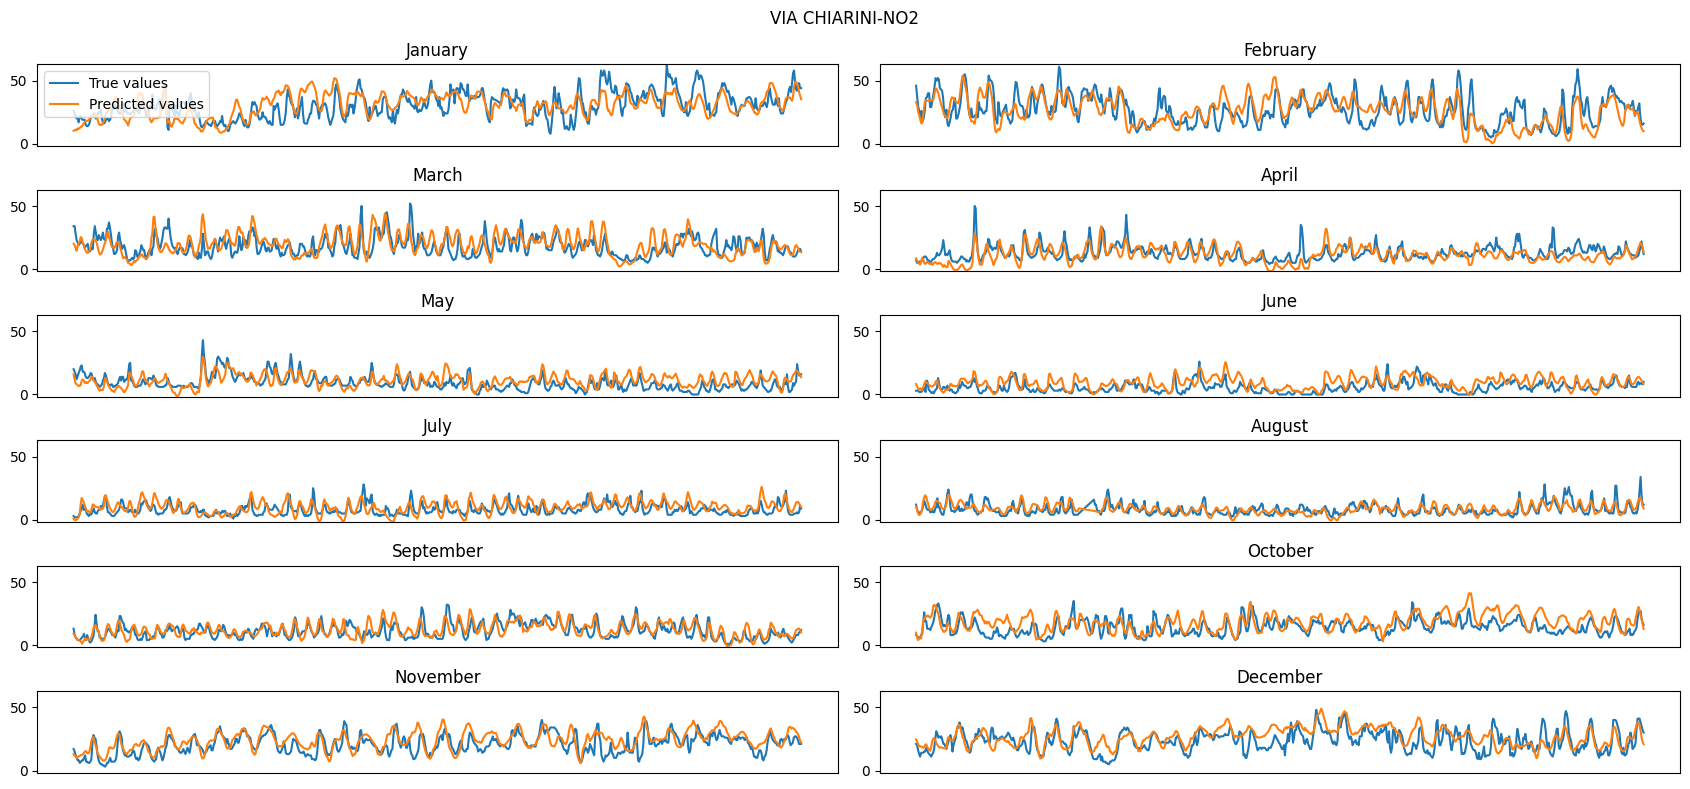

root_mean_squared_error: 0.5146077034409647
r2_score: 0.5706656408172713
mean_absolute_error: 0.39634210277558235
mean_squared_error: 0.2648210884407839


In [112]:
plot_months_predictions(test_sets[station][agent]['y'], conv_pred_df, dist_dict=station_dists[station][agent], metrics=metrics, title=f'{station}-{agent}')

### **Daily Models**

In [113]:
daily_models = {} # contains tuples: (ModelClass, model_params:dict, training_params:dict, uses_sequences:bool|dict)

#### Random Forest Regressor

##### *Models*

In [114]:
rfr_params = {
    'n_estimators':100,
    'max_depth':10,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE
}

daily_models['Random Forest Regressor'] = (RandomForestRegressor, rfr_params, None, False)

In [115]:
rfr2_params = {
    'n_estimators':150,
    'max_depth':20,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE
}

daily_models['Random Forest Regressor 2'] = (RandomForestRegressor, rfr2_params, None, False)

##### *Testing*

In [116]:
station = 'GIARDINI MARGHERITA'
agent = 'PM10'

selected_daily_rfr = 'Random Forest Regressor'

In [117]:
rfr_daily_model = RandomForestRegressor(**daily_models[selected_daily_rfr][1])
rfr_daily_model.fit(merged_train_sets[agent]['x'], merged_train_sets[agent]['y'].to_numpy().ravel())
rfr_daily_pred = rfr_daily_model.predict(test_sets[station][agent]['x'])
rfr_daily_pred_df = pd.DataFrame(rfr_daily_pred, index=test_sets[station][agent]['y'].index)

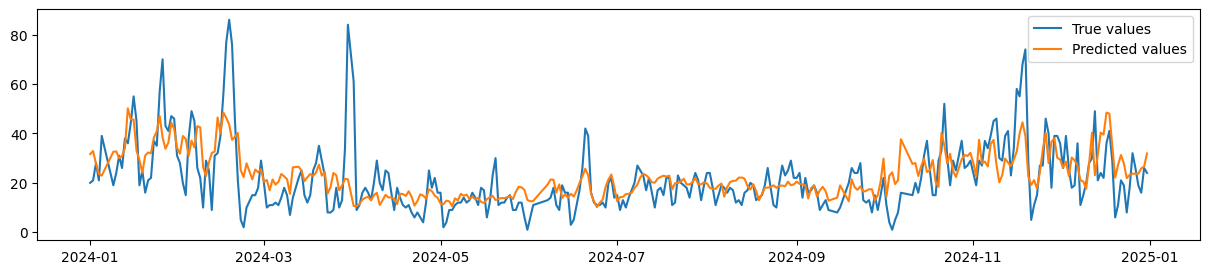

root_mean_squared_error: 0.7236807594977694
r2_score: 0.4197930582142969
mean_absolute_error: 0.5137615558222252
mean_squared_error: 0.5237138416672684


In [118]:
plot_year_predictions(test_sets[station][agent]['y'], rfr_daily_pred_df, dist_dict=station_dists[station][agent], metrics=metrics)

#### XGBoost Regressor

##### *Models*

In [119]:
xgbr_params = {
    'objective': "reg:squarederror",
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.07,
    'subsample': 0.9,
    'random_state': RANDOM_STATE,
}

daily_models['XGB Regressor'] = (xgb.XGBRegressor, xgbr_params, None, False)

In [120]:
xgbr2_params = {
    'objective': "reg:squarederror",
    'n_estimators': 150,
    'max_depth': 10,
    'learning_rate': 0.05,
    'subsample': 0.9,
    'random_state': RANDOM_STATE,
}

daily_models['XGB Regressor 2'] = (xgb.XGBRegressor, xgbr2_params, None, False)

##### *Testing*

In [121]:
station = 'GIARDINI MARGHERITA'
agent = 'PM10'

selected_daily_xgbr = 'XGB Regressor'

In [122]:
validation_ratio = 0.1

X_train, y_train = merged_train_sets[agent]['x'], merged_train_sets[agent]['y']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_ratio, random_state=42, shuffle=True)
validation_data = [(X_val, y_val)]

xgbr_daily_model = xgb.XGBRegressor(**hour_models[selected_daily_xgbr][1])
xgbr_daily_model.fit(X_train, y_train, eval_set=validation_data)
xgbr_daily_pred = xgbr_daily_model.predict(test_sets[station][agent]['x'])
xgbr_daily_pred_df = pd.DataFrame(xgbr_daily_pred, index=test_sets[station][agent]['y'].index)

[0]	validation_0-mae:0.75119
[1]	validation_0-mae:0.73012
[2]	validation_0-mae:0.71296
[3]	validation_0-mae:0.69435
[4]	validation_0-mae:0.67693
[5]	validation_0-mae:0.65996
[6]	validation_0-mae:0.64720
[7]	validation_0-mae:0.63297
[8]	validation_0-mae:0.61990
[9]	validation_0-mae:0.60822
[10]	validation_0-mae:0.59853
[11]	validation_0-mae:0.58831
[12]	validation_0-mae:0.57903
[13]	validation_0-mae:0.56930
[14]	validation_0-mae:0.56145
[15]	validation_0-mae:0.55249
[16]	validation_0-mae:0.54599
[17]	validation_0-mae:0.53921
[18]	validation_0-mae:0.53342
[19]	validation_0-mae:0.52571
[20]	validation_0-mae:0.52207
[21]	validation_0-mae:0.51901
[22]	validation_0-mae:0.51434
[23]	validation_0-mae:0.51037
[24]	validation_0-mae:0.50328
[25]	validation_0-mae:0.49955
[26]	validation_0-mae:0.49542
[27]	validation_0-mae:0.49175
[28]	validation_0-mae:0.48844
[29]	validation_0-mae:0.48665
[30]	validation_0-mae:0.48311
[31]	validation_0-mae:0.47998
[32]	validation_0-mae:0.47688
[33]	validation_0-ma

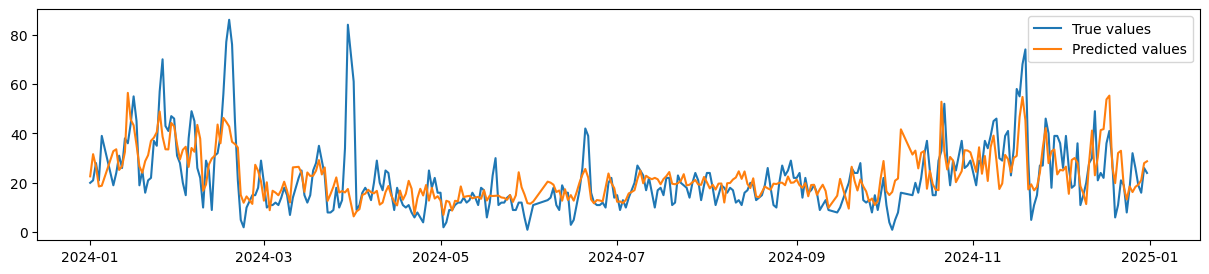

root_mean_squared_error: 0.7240481696102145
r2_score: 0.41920377071774817
mean_absolute_error: 0.5035180523049082
mean_squared_error: 0.5242457519159018


In [123]:
plot_year_predictions(test_sets[station][agent]['y'], xgbr_daily_pred_df, dist_dict=station_dists[station][agent], metrics=metrics)

#### Feed Forward Neural Network

##### *Models*

In [124]:
ffnn_daily_params = {
    'input_size': n_daily_features,
    'neurons': [1024, 512, 256, 128],
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=3e-4),
    'loss': 'mean_absolute_error'
}

ffnn_daily_train_params = {
    'epochs':20,
    'batch_size':32,
}

daily_models['Feed Forward NN'] = (build_ffnn_model, ffnn_daily_params, ffnn_daily_train_params, False)

In [125]:
bn_ffnn_daily_params = {
    'input_size': n_daily_features,
    'neurons': [1024, 512, 256, 128],
    'batch_norm': True,
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=3e-4),
    'loss': 'mean_absolute_error'
}

bn_ffnn_daily_train_params = {
    'epochs':20,
    'batch_size':32,
}

daily_models['Feed Forward NN BatchNorm'] = (build_ffnn_model, bn_ffnn_daily_params, bn_ffnn_daily_train_params, False)

##### *Testing*

In [146]:
station = 'GIARDINI MARGHERITA'
agent = 'PM10'

selected_daily_ffnn = 'Feed Forward NN'

Epoch 1/10
149/149 [==============================] - 1s 5ms/step - loss: 0.5585 - val_loss: 0.5433
Epoch 2/10
149/149 [==============================] - 1s 5ms/step - loss: 0.4857 - val_loss: 0.5070
Epoch 3/10
149/149 [==============================] - 1s 5ms/step - loss: 0.4657 - val_loss: 0.4978
Epoch 4/10
149/149 [==============================] - 1s 5ms/step - loss: 0.4461 - val_loss: 0.4916
Epoch 5/10
149/149 [==============================] - 1s 5ms/step - loss: 0.4352 - val_loss: 0.4770
Epoch 6/10
149/149 [==============================] - 1s 5ms/step - loss: 0.4245 - val_loss: 0.4740
Epoch 7/10
149/149 [==============================] - 1s 5ms/step - loss: 0.4121 - val_loss: 0.4615
Epoch 8/10
149/149 [==============================] - 1s 5ms/step - loss: 0.4010 - val_loss: 0.4425
Epoch 9/10
149/149 [==============================] - 1s 5ms/step - loss: 0.3877 - val_loss: 0.4387
Epoch 10/10
149/149 [==============================] - 1s 5ms/step - loss: 0.3774 - val_loss: 0.4524

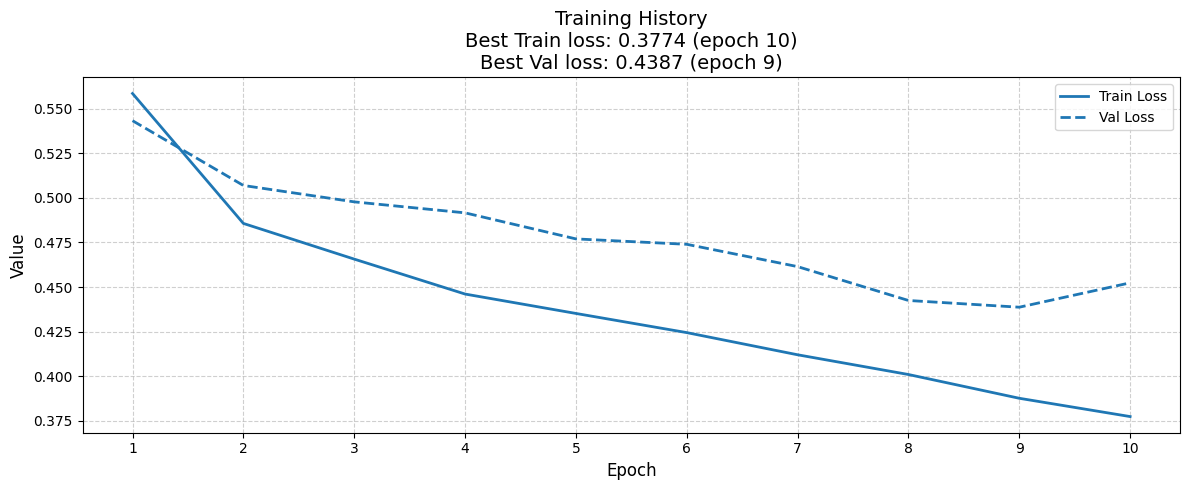

11/11 [==============================] - 0s 1ms/step


In [147]:
tf.keras.backend.clear_session()  
set_random_seed(42) 

validation_ratio = 0.1
X_train, y_train = merged_train_sets[agent]['x'], merged_train_sets[agent]['y']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_ratio, random_state=42, shuffle=True)
validation_data = [(X_val, y_val)]

ffnn_daily_model = build_ffnn_model(**daily_models[selected_daily_ffnn][1])
ffnn_daily_history = ffnn_daily_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    **hour_models[selected_daily_ffnn][2]
)
plot_history(ffnn_daily_history)
ffnn_daily_pred = ffnn_daily_model.predict(test_sets[station][agent]['x'])
ffnn_daily_pred_df = pd.DataFrame(ffnn_daily_pred, index=test_sets[station][agent]['y'].index)

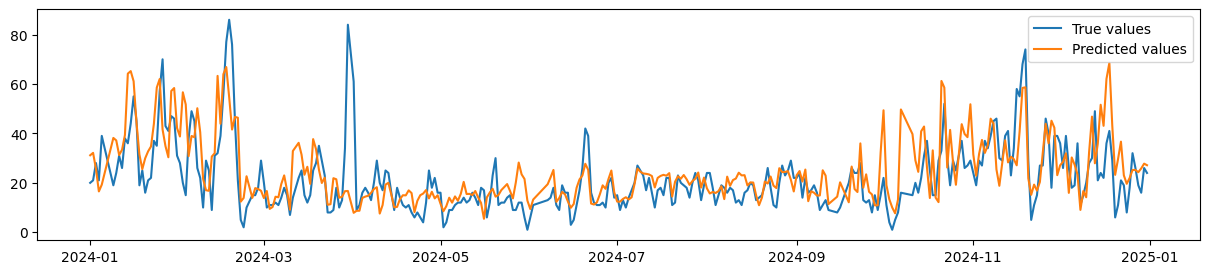

root_mean_squared_error: 0.8051380766950538
r2_score: 0.28182612982548283
mean_absolute_error: 0.5667203337185606
mean_squared_error: 0.6482473225442102


In [148]:
plot_year_predictions(test_sets[station][agent]['y'], ffnn_daily_pred_df, dist_dict=station_dists[station][agent], metrics=metrics)

## **Agents Evaluations**

### Hourly Models

In [ ]:
hour_results = train_models_1_per_agent(
    hour_models, train_sets, merged_train_sets, test_sets, metrics,
    to_execute={
        'agents':'all',
        'stations':'all',
        'models':'all',
    },
    ignore={
        'stations':[],
        'agents':['PM10','PM2.5'],
        'models':[]
        },
    random_state=RANDOM_STATE,
    v=1
)

Train settings:
stations: ['GIARDINI MARGHERITA', 'PORTA SAN FELICE', 'VIA CHIARINI']
agents: ['NO2', 'O3', 'C6H6', 'CO']
models: ['Random Forest Regressor', 'Random Forest Regressor 2', 'XGB Regressor', 'XGB Regressor 2', 'LSTM', 'LSTM-masked', 'LSTM 2', 'LSTM 2-masked', 'Feed Forward NN', 'Feed Forward NN 2', 'Conv1D', 'Conv1D 2', 'Conv1D 3']
Agent NO2
> Random Forest Regressor model
> Random Forest Regressor 2 model
> XGB Regressor model
> XGB Regressor 2 model
> LSTM model
> LSTM-masked model
> LSTM 2 model
> LSTM 2-masked model
> Feed Forward NN model
> Feed Forward NN 2 model
> Conv1D model
> Conv1D 2 model
> Conv1D 3 model
Agent O3
> Random Forest Regressor model
> Random Forest Regressor 2 model
> XGB Regressor model
> XGB Regressor 2 model
> LSTM model
> LSTM-masked model
> LSTM 2 model
> LSTM 2-masked model
> Feed Forward NN model
> Feed Forward NN 2 model
> Conv1D model
> Conv1D 2 model
> Conv1D 3 model
Agent C6H6
> Random Forest Regressor model
> Random Forest Regressor 2 m

Since that we evaluated per-station, we need to compute the overall metric of each model for each station. To do so, we simply apply the inverse formula of the metric and then normalize across all the dataset.

*We could also put together the predictions and compute the metric, or directly evaluate per agent*.

In [ ]:
hour_extracted_data = extract_model_scores(hour_results, test_sets)
hour_extracted_data_df = extracted_scores_to_dataframe(hour_extracted_data)

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(hour_extracted_data_df.sort_values(by=['Agent','root_mean_squared_error']))

,Agent,Model,root_mean_squared_error,mean_absolute_error,mean_squared_error
40,C6H6,Conv1D 2,0.566070,0.355883,0.320435
39,C6H6,Conv1D,0.567718,0.354768,0.322304
32,C6H6,LSTM,0.570564,0.347328,0.325544
41,C6H6,Conv1D 3,0.585756,0.366531,0.343110
30,C6H6,XGB Regressor,0.593932,0.362918,0.352755
28,C6H6,Random Forest Regressor,0.594912,0.377433,0.353921
29,C6H6,Random Forest Regressor 2,0.595330,0.377656,0.354418
34,C6H6,LSTM 2,0.598238,0.377063,0.357888
33,C6H6,LSTM-masked,0.622386,0.394322,0.387365
31,C6H6,XGB Regressor 2,0.622836,0.397652,0.387925


And we can display the best model for each station-agent

In [ ]:
best_hourly = hour_extracted_data_df.loc[hour_extracted_data_df.groupby(by=['Agent'])['root_mean_squared_error'].idxmin()]
display(best_hourly)

,Agent,Model,root_mean_squared_error,mean_absolute_error,mean_squared_error
40,C6H6,Conv1D 2,0.566070,0.355883,0.320435
46,CO,LSTM,0.651562,0.509523,0.424533
4,NO2,LSTM,0.682500,0.534704,0.500349
18,O3,LSTM,0.362456,0.271118,0.132266


Contrarely to the station-agent models, LSTMs models perform better accross stations. They are therefore more suitable to develop robust models that could work well when presented with new stations or agents.

#### **Comparison**

In [160]:
hourly_comparison_results = []
comparison_agents = best_hourly['Agent']
comparison_models = best_hourly['Model']
comparison_models = ['Conv1D 2']+['LSTM']*3
for station in hour_results:
    for agent, model in zip(comparison_agents, comparison_models):
        if agent in hour_results[station]:
            comparison_metrics = hour_results[station][agent][model]['metric_scores']
            hourly_comparison_results.append({
                "Station": station,
                "Agent": agent,
                "Model": model,
                **comparison_metrics
            })

hourly_comparison_df = pd.DataFrame(hourly_comparison_results)
display(hourly_comparison_df)

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,mean_squared_error
0,GIARDINI MARGHERITA,NO2,LSTM,0.672791,0.357852,0.482571,0.452647
1,GIARDINI MARGHERITA,O3,LSTM,0.429895,0.792413,0.322652,0.184810
2,PORTA SAN FELICE,C6H6,Conv1D 2,0.566202,0.651979,0.356327,0.320585
3,PORTA SAN FELICE,CO,LSTM,0.767307,0.436927,0.602599,0.588761
4,PORTA SAN FELICE,NO2,LSTM,1.006607,-0.875553,0.816145,1.013258
5,VIA CHIARINI,NO2,LSTM,0.576445,0.461284,0.424121,0.332289
6,VIA CHIARINI,O3,LSTM,0.348473,0.860141,0.261967,0.121433


TODO dopo rieseguito 5.1

### Daily Models

In [39]:
daily_results = train_models_1_per_agent(
    daily_models, train_sets, merged_train_sets, test_sets, metrics,
    to_execute={
        'agents':['PM10','PM2.5'],
        'stations':'all',
        'models':'all',
        },
    ignore={
        'stations':[],
        'agents':[],
        'models':[]
        },
    v=1
)

Train settings:
stations: ['GIARDINI MARGHERITA', 'PORTA SAN FELICE', 'VIA CHIARINI']
agents: ['PM10', 'PM2.5']
models: ['Random Forest Regressor', 'Random Forest Regressor 2', 'XGB Regressor', 'XGB Regressor 2', 'Feed Forward NN', 'Feed Forward NN BatchNorm']
Agent PM10
> Random Forest Regressor model
> Random Forest Regressor 2 model
> XGB Regressor model
> XGB Regressor 2 model
> Feed Forward NN model
> Feed Forward NN BatchNorm model
Agent PM2.5
> Random Forest Regressor model
> Random Forest Regressor 2 model
> XGB Regressor model
> XGB Regressor 2 model
> Feed Forward NN model
> Feed Forward NN BatchNorm model


In [40]:
daily_extracted_data = extract_model_scores(daily_results, test_sets)
daily_extracted_data_df = extracted_scores_to_dataframe(daily_extracted_data)

In [41]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(daily_extracted_data_df.sort_values(by=['Agent','root_mean_squared_error']))

,Agent,Model,root_mean_squared_error,mean_absolute_error,mean_squared_error
0,PM10,Random Forest Regressor,0.750388,0.536442,0.565660
5,PM10,Feed Forward NN BatchNorm,0.754000,0.523257,0.570822
1,PM10,Random Forest Regressor 2,0.759755,0.547435,0.580058
2,PM10,XGB Regressor,0.772805,0.558383,0.600883
4,PM10,Feed Forward NN,0.786282,0.556495,0.621851
3,PM10,XGB Regressor 2,0.797466,0.572639,0.639566
10,PM2.5,Feed Forward NN,0.680360,0.465767,0.464047
11,PM2.5,Feed Forward NN BatchNorm,0.694646,0.479680,0.484957
7,PM2.5,Random Forest Regressor 2,0.695833,0.492943,0.485186
6,PM2.5,Random Forest Regressor,0.701513,0.493267,0.492974


In [42]:
display(daily_extracted_data_df.loc[daily_extracted_data_df.groupby(by=['Agent'])['root_mean_squared_error'].idxmin()])

,Agent,Model,root_mean_squared_error,mean_absolute_error,mean_squared_error
0,PM10,Random Forest Regressor,0.750388,0.536442,0.565660
10,PM2.5,Feed Forward NN,0.680360,0.465767,0.464047


#### **Comparison**

In [ ]:
comparison = [
    ("GIARDINI MARGHERITA", "PM2.5", "Feed Forward NN"),
    ("PORTA SAN FELICE", "PM10", "Feed Forward NN"),
    ("PORTA SAN FELICE", "PM2.5", "Feed Forward NN"),
    ("VIA CHIARINI", "PM10", "Random Forest Regressor"),
]

daily_comparison_results = []
for station, agent, model in comparison:
    comparison_metrics = daily_results[station][agent][model]['metric_scores']
    daily_comparison_results.append({
        "Station": station,
        "Agent": agent,
        "Model": model,
        **comparison_metrics
    })

daily_comparison_df = pd.DataFrame(daily_comparison_results)
display(daily_comparison_df)

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,mean_squared_error
0,GIARDINI MARGHERITA,PM2.5,Feed Forward NN,0.714714,0.492823,0.476467,0.510816
1,PORTA SAN FELICE,PM10,Feed Forward NN,0.732853,0.468371,0.504960,0.537074
2,PORTA SAN FELICE,PM2.5,Feed Forward NN,0.646672,0.594076,0.455275,0.418184
3,VIA CHIARINI,PM10,Random Forest Regressor,0.822801,0.343498,0.615329,0.677001


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Station</th>
      <th>Agent</th>
      <th>Model</th>
      <th>root_mean_squared_error</th>
      <th>r2_score</th>
      <th>mean_absolute_error</th>
      <th>mean_squared_error</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>10</th>
      <td>GIARDINI MARGHERITA</td>
      <td>PM2.5</td>
      <td>Feed Forward NN</td>
      <td>0.704822</td>
      <td>0.506765</td>
      <td>0.491546</td>
      <td>0.496775</td>
    </tr>
    <tr>
      <th>16</th>
      <td>PORTA SAN FELICE</td>
      <td>PM10</td>
      <td>Feed Forward NN</td>
      <td>0.702841</td>
      <td>0.511023</td>
      <td>0.464813</td>
      <td>0.493985</td>
    </tr>
    <tr>
      <th>22</th>
      <td>PORTA SAN FELICE</td>
      <td>PM2.5</td>
      <td>Feed Forward NN</td>
      <td>0.642601</td>
      <td>0.599170</td>
      <td>0.450156</td>
      <td>0.412936</td>
    </tr>
    <tr>
      <th>24</th>
      <td>VIA CHIARINI</td>
      <td>PM10</td>
      <td>Random Forest Regressor</td>
      <td>0.845451</td>
      <td>0.306857</td>
      <td>0.646139</td>
      <td>0.714787</td>
    </tr>
  </tbody>
</table>


The best models are the same as the station-agent models.
The metric scores are really similar, maybe the fact that the two pollutants are really highly correlated doesn't introduce new training data.

To further inspect their performance, we compare the AQI values.

In any case, we were able to achieve similar results only using one model for each agent.